In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, pickle
sys.path.append('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/code/multiple_barriers')
from multiple_barriers.agent_replay import AgentPOMDP
from multiple_barriers.utils import plot_maze, load_env

In [2]:
env            = 'tolman123'
env_file_path  = '/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/code/mazes/' + env + '.txt'
env_config     = load_env(env_file_path)

# --- Specify agent parameters ---
pag_config = {
    'alpha'          : 1,
    'beta'           : 2, 
    'need_beta'      : 2,
    'gain_beta'      : 60,          
    'gamma'          : 0.9,
    'policy_type'    : 'softmax'
}

ag_config = {
    'alpha_r'        : 1,         # offline learning rate
    'horizon'        : 10,        # planning horizon (minus 1)
    'xi'             : 0.001,     # EVB replay threshold
    'num_sims'       : 2000,      # number of MC simulations for need
    'sequences'      : False,
    'max_seq_len'    : 5,        
    'env_name'       : env,       # gridworld name
}

env_config['barriers'] = [1, 1, 0]

agent = AgentPOMDP(*[pag_config, ag_config, env_config])

### Example replays

In [4]:
Q_MB  = agent._solve_mb(1e-5)

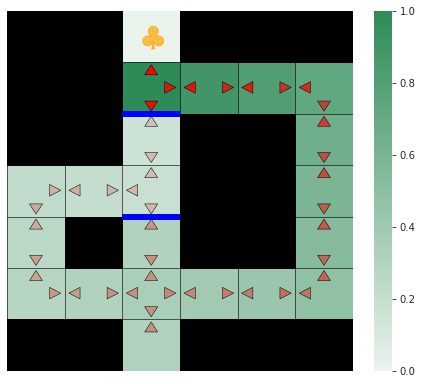

In [5]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, Q_MB, agent)
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/rldm_poster/tolman1/q_mb.svg', transparent=True)

### Exploration probability

In [6]:
np.random.seed(2)

agent.M      = np.array([[1, 1], [0, 1], [1, 0]])

agent.state  = 38 # start state
M_range      = [[0, 1], [1, 7], [1, 5], [1, 3], [1, 1], [3, 1], [5, 1], [7, 1], [1, 0]]
qs           = []

for M in M_range:
    agent.Q       = Q_MB.copy()
    agent.M[0, :] = M
    
    _, _, _  = agent._replay()
    
    Q_after  = agent.Q.copy()
    
    qs      += [Q_after[14, :].copy(), Q_after[20, :].copy(), Q_after[19, :].copy(), Q_after[18, :].copy(), Q_after[24, :].copy(), Q_after[30, :].copy(), Q_after[31, :].copy(), Q_after[32, :].copy()]

1 - Replay 1/1 [<14, (0.12, 0.00, 1.00)>, 0] horizon 8, q_old: 0.15, q_new: 0.24, gain: 0.06, need: 0.03, evb: 0.00
2 - Replay 1/1 [<20, (0.12, 0.00, 1.00)>, 0] horizon 7, q_old: 0.15, q_new: 0.22, gain: 0.03, need: 0.03, evb: 0.00
1 - Replay 1/1 [<14, (0.17, 0.00, 1.00)>, 0] horizon 8, q_old: 0.15, q_new: 0.28, gain: 0.08, need: 0.03, evb: 0.00
2 - Replay 1/1 [<20, (0.17, 0.00, 1.00)>, 0] horizon 7, q_old: 0.15, q_new: 0.25, gain: 0.06, need: 0.03, evb: 0.00
1 - Replay 1/1 [<14, (0.25, 0.00, 1.00)>, 0] horizon 8, q_old: 0.15, q_new: 0.34, gain: 0.12, need: 0.03, evb: 0.00
2 - Replay 1/1 [<20, (0.25, 0.00, 1.00)>, 0] horizon 7, q_old: 0.15, q_new: 0.30, gain: 0.11, need: 0.03, evb: 0.00
3 - Replay 1/1 [<19, (0.25, 0.00, 1.00)>, 3] horizon 6, q_old: 0.17, q_new: 0.27, gain: 0.06, need: 0.05, evb: 0.00
4 - Replay 1/1 [<18, (0.25, 0.00, 1.00)>, 3] horizon 5, q_old: 0.19, q_new: 0.25, gain: 0.01, need: 0.10, evb: 0.00
1 - Replay 1/1 [<14, (0.50, 0.00, 1.00)>, 0] horizon 8, q_old: 0.15, q_n

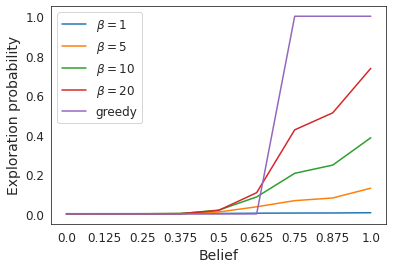

In [13]:
betas = [1, 5, 10, 20]

x = np.arange(len(M_range))

for beta in betas:

    agent.beta = beta
    probs = np.zeros(len(M_range))
    for i in range(0, len(qs), 8):
        probs[i//8] = agent._policy(qs[i])[0]*agent._policy(qs[i+1])[0]*agent._policy(qs[i+2])[3]*agent._policy(qs[i+3])[3]*agent._policy(qs[i+4])[0]*agent._policy(qs[i+5])[0]*agent._policy(qs[i+6])[2]*agent._policy(qs[i+7])[2]
    plt.plot(x, probs, label=r'$\beta=%u$'%beta)

probs = np.zeros(len(M_range))
for i in range(7, len(qs), 8):
    probs[i//8] = (qs[i][2] == np.nanmax(qs[i]))
plt.plot(x, probs, label='greedy')

plt.ylim(-0.05, 1.05)
# plt.xlim(0, 1)

plt.xticks(x, np.linspace(0, 1, len(x)), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Belief', fontsize=14)
plt.ylabel('Exploration probability', fontsize=14)
plt.legend(prop={'size':12})
plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/paper/figures/fig5/fig5.png')

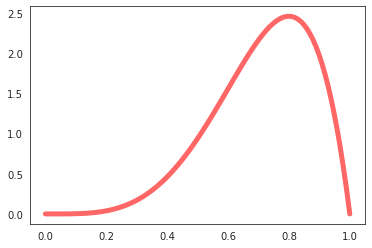

In [36]:
import scipy

a, b = 5, 2

x = np.linspace(0, 1, 100)

plt.plot(x, scipy.stats.beta.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label='beta pdf')